In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from data_pipeline import EXPORTED as data_pipeline
from tensorflow import keras

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total samples : 1139
Total samples : 12000


The total number of ingredients : 24
The lowest number of images per category : 508
The highest number of images per category : 550
The average number of images per category : 547
The total number of ingredients : 501
The average number of ingredients for each dish (recipes5k + food101) : 10


In [12]:
class BaseModel:
    def __init__(
        self,
        input_shape,
        total_food_category,
        total_ingredients_category,
        name,
        model_config_name,
    ):
        self.input_shape = input_shape
        self.total_food_category = total_food_category
        self.total_ingredients_category = total_ingredients_category
        self.model = None
        self.name = name
        self.model_config_name = model_config_name

    def build(
        self,
        independent_category_units,
        independent_ingredients_units,
        independent_protein_units,
        independent_calorie_units,
        independent_carbs_units,
        independent_fat_units,
        shared_units,
    ):
        raise NotImplementedError

    def compile_model(self, optimizer):
        assert self.model is not None
        category_classification_loss = keras.losses.CategoricalCrossentropy()
        calorie_regression_loss = keras.losses.MeanAbsoluteError()
        carbs_regression_loss = keras.losses.MeanAbsoluteError()
        protein_regression_loss = keras.losses.MeanAbsoluteError()
        fat_regression_loss = keras.losses.MeanAbsoluteError()
        ingredient_multilabel_loss = keras.losses.BinaryCrossentropy()
        category_classification_metrics = (
            [
                keras.metrics.CategoricalAccuracy(name="acc"),
                keras.metrics.Precision(name="precision"),
                keras.metrics.Recall(name="recall"),
            ],
        )

        calorie_regression_metrics = [keras.metrics.MeanAbsoluteError(name="MAE")]
        carbs_regression_metrics = [keras.metrics.MeanAbsoluteError(name="MAE")]
        protein_regression_metrics = [keras.metrics.MeanAbsoluteError(name="MAE")]
        fat_regression_metrics = [keras.metrics.MeanAbsoluteError(name="MAE")]
        ingredient_multilabel_metrics = (
            [
                keras.metrics.Precision(name="precision"),
                keras.metrics.Recall(name="recall"),
            ],
        )
        category_classification_loss_weights = 1.0
        ingredient_multilabel_loss_weights = 1.0
        calorie_regression_loss_weights = 1.0
        carbs_regression_loss_weights = 1.0
        protein_regression_loss_weights = 1.0
        fat_regression_loss_weights = 1.0

        self.model.compile(
            optimizer=optimizer,
            loss={
                "category_output": category_classification_loss,
                "calorie_output": calorie_regression_loss,
                "carbs_output": carbs_regression_loss,
                "protein_output": protein_regression_loss,
                "fat_output": fat_regression_loss,
                "ingredients_output": ingredient_multilabel_loss,
            },
            metrics={
                "category_output": category_classification_metrics,
                "calorie_output": calorie_regression_metrics,
                "carbs_output": carbs_regression_metrics,
                "protein_output": protein_regression_metrics,
                "fat_output": fat_regression_metrics,
                "ingredients_output": ingredient_multilabel_metrics,
            },
            loss_weights={
                "category_output": category_classification_loss_weights,
                "calorie_output": calorie_regression_loss_weights,
                "carbs_output": carbs_regression_loss_weights,
                "protein_output": protein_regression_loss_weights,
                "fat_output": fat_regression_loss_weights,
                "ingredients_output": ingredient_multilabel_loss_weights,
            },
        )

    def freeze_category_classification_layers(self):
        assert self.model is not None
        submodel = self.model.get_layer("category_output")
        submodel.trainable = False

    def freeze_convolution_base(self):
        assert self.model is not None
        submodel = self.model.get_layer("efficientnetB1")
        submodel.trainable = False

    def get_callbacks(self):
        tensorboard_dir = f"./drive/MyDrive/FoodCaloModel/models/logs/{self.name}/{self.model_config_name}"
        checkpoint_dir = f"./drive/MyDrive/FoodCaloModel/temp/checkpoint/{self.name}/{self.model_config_name}"
        checkpoint_model_path = checkpoint_dir + "/model"
        checkpoint_weights_path = checkpoint_dir + "/weights/ckpt"
        checkpoint_model_callback = keras.callbacks.ModelCheckpoint(
            checkpoint_model_path, monitor="val_loss", save_best_only=True, mode="min"
        )
        checkpoint_weights_callback = keras.callbacks.ModelCheckpoint(
            checkpoint_weights_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            mode="min",
        )
        reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
        )
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_dir)
        early_stopping_callback = keras.callbacks.EarlyStopping("val_loss", patience=8)
        return [
            tensorboard_callback,
            early_stopping_callback,
            checkpoint_model_callback,
            checkpoint_weights_callback,
            reduce_lr_callback,
        ]

    # Layers from bottom to top (classifier)  #
    def get_input_layer(self):
        return keras.Input(shape=self.input_shape)

    def get_augmentation_layers(self):
        input_layer = keras.layers.Input(shape=self.input_shape)
        augmentation_layer = keras.layers.RandomFlip()(input_layer)
        augmentation_layer = keras.layers.RandomRotation(0.2)(augmentation_layer)
        augmentation_layer = keras.layers.RandomZoom(0.2)(augmentation_layer)
        augmentation_layer = keras.layers.RandomTranslation(0.2, 0.2)(augmentation_layer)
        augmentation_layer = keras.layers.RandomRotation(0.2)(augmentation_layer)

        return keras.Model(
            inputs=input_layer, outputs=augmentation_layer, name="augmentation_layers"
        )

    def get_preprocess_layers(self, input_tensor):
        raise NotImplementedError

    def get_convolution_block(self):
        raise NotImplementedError

    def get_shared_layers(self, input_tensor, *num_units):
        input_layer = keras.layers.Input(shape=input_tensor.shape[1:])
        shared_layer = keras.layers.Flatten()(input_layer)
        shared_layer = keras.layers.Dense(
            num_units[0], activation="relu", name="shared_dense_1"
        )(shared_layer)
        shared_layer = keras.layers.BatchNormalization()(shared_layer)
        shared_layer = keras.layers.Dropout(0.2)(shared_layer)
        shared_layer = keras.layers.BatchNormalization()(shared_layer)
        output_layer = keras.layers.Dropout(0.2)(shared_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="shared_layers"
        )

    def get_category_classification_layers(
        self, input_tensor, total_categories, *num_units
    ):
        input_layer = keras.layers.Input(shape=input_tensor.shape[1:])
        x = keras.layers.Dense(
            num_units[0], activation="relu", name="category_dense_1"
        )(input_layer)
        x = keras.layers.BatchNormalization()(x)
        category_classification_layer = keras.layers.Dense(
            total_categories, activation="softmax", name="category_output_layer"
        )(x)
        output_model = keras.Model(
            inputs=input_layer,
            outputs=category_classification_layer,
            name="category_output",
        )
        return output_model

    def get_calorie_regression_layers(self, input_tensor, *num_units):
        input_layer = keras.layers.Input(shape=input_tensor.shape[1:])
        x = keras.layers.Dense(num_units[0], activation="relu", name="calorie_dense_1")(
            input_layer
        )
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(num_units[1], activation="relu", name="calorie_dense_2")(
            x
        )
        x = keras.layers.BatchNormalization()(x)
        calorie_regression_layers = keras.layers.Dense(1, name="calorie_output_layer")(
            x
        )
        return keras.Model(
            inputs=input_layer, outputs=calorie_regression_layers, name="calorie_output"
        )

    def get_carbs_regression_layers(self, input_tensor, *num_units):
        input_layer = keras.layers.Input(shape=input_tensor.shape[1:])
        x = keras.layers.Dense(num_units[0], activation="relu", name="carbs_dense_1")(
            input_layer
        )
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(num_units[1], activation="relu", name="carbs_dense_2")(x)
        x = keras.layers.BatchNormalization()(x)
        carbs_regression_layers = keras.layers.Dense(1, name="carbs_output_layer")(x)
        return keras.Model(
            inputs=input_layer, outputs=carbs_regression_layers, name="carbs_output"
        )

    def get_protein_regression_layers(self, input_tensor, *num_units):
        input_layer = keras.layers.Input(shape=input_tensor.shape[1:])
        x = keras.layers.Dense(num_units[0], activation="relu", name="protein_dense_1")(
            input_layer
        )
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(num_units[1], activation="relu", name="protein_dense_2")(
            x
        )
        x = keras.layers.BatchNormalization()(x)
        protein_regression_layers = keras.layers.Dense(1, name="protein_output_layer")(
            x
        )
        return keras.Model(
            inputs=input_layer, outputs=protein_regression_layers, name="protein_output"
        )

    def get_fat_regression_layers(self, input_tensor, *num_units):
        input_layer = keras.layers.Input(shape=input_tensor.shape[1:])
        x = keras.layers.Dense(num_units[0], activation="relu", name="fat_dense_1")(
            input_layer
        )
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dense(num_units[1], activation="relu", name="fat_dense_2")(x)
        x = keras.layers.BatchNormalization()(x)
        fat_regression_layers = keras.layers.Dense(1, name="fat_output_layer")(x)
        return keras.Model(
            inputs=input_layer, outputs=fat_regression_layers, name="fat_output"
        )

    def get_ingredients_multilabel_layers(
        self, input_tensor, total_ingredients, *num_units
    ):
        input_layer = keras.layers.Input(shape=input_tensor.shape[1:])
        ingredients_multilabel_layers = keras.layers.Dense(
            num_units[0], activation="relu", name="ingredients_dense_1"
        )(input_layer)
        ingredients_multilabel_layers = keras.layers.BatchNormalization()(
            ingredients_multilabel_layers
        )
        ingredients_multilabel_layers = keras.layers.Dense(
            num_units[1], activation="relu", name="ingredients_dense_2"
        )(ingredients_multilabel_layers)
        ingredients_multilabel_layers = keras.layers.BatchNormalization()(
            ingredients_multilabel_layers
        )
        ingredients_multilabel_layers = keras.layers.Dense(
            num_units[2], activation="relu", name="ingredients_dense_3"
        )(ingredients_multilabel_layers)
        ingredients_multilabel_layers = keras.layers.BatchNormalization()(
            ingredients_multilabel_layers
        )
        output_layers = keras.layers.Dense(
            total_ingredients, activation="sigmoid", name="ingredients_output_layer"
        )(ingredients_multilabel_layers)
        return keras.Model(
            inputs=input_layer, outputs=output_layers, name="ingredients_output"
        )

    # End of layers  #

    def load_model(self, path):
        self.model = keras.models.load_model(path)

    def print_summary(self):
        assert (
            self.model is not None
        ), "Please run build_and_compile before printing summary."
        self.model.summary(expand_nested=True, show_trainable=True)

    def save_model(self, path):
        assert self.model is not None
        self.model.save(path, save_format="h5")

    def train_model(self, **kwargs):
        assert self.model is not None, "No model found."
        return self.model.fit(**kwargs, callbacks=self.get_callbacks())

    def unfreeze_category_classification_layers(self):
        assert self.model is not None
        submodel = self.model.get_layer("category_output")
        submodel.trainable = False

    def unfreeze_convolution_base(self, fine_tune_at=0):
        assert self.model is not None
        submodel = self.model.get_layer("efficientnetb1")
        submodel.trainable = True
        for layer in submodel.layers[:fine_tune_at]:
            layer.trainable = False

In [5]:
class FlatModel(BaseModel):
    def __init__(
        self,
        input_shape,
        total_food_category,
        total_ingredients_category,
        name,
        model_config_name,
    ):
        super().__init__(
            input_shape,
            total_food_category,
            total_ingredients_category,
            name,
            model_config_name,
        )

    def build(
        self,
        shared_units,
        independent_category_units,
        independent_protein_units,
        independent_fat_units,
        independent_carbs_units,
        independent_calorie_units,
        independent_ingredients_units,
    ):
        model_inputs = self.get_input_layer()
        prev_layer = self.get_augmentation_layers()(model_inputs)
        prev_layer = self.get_preprocess_layers(prev_layer)(prev_layer)
        prev_layer = self.get_convolution_block()(prev_layer)
        prev_layer = self.get_shared_layers(prev_layer, *shared_units)(prev_layer)
        category_classification_head = self.get_category_classification_layers(
            prev_layer, self.total_food_category, *independent_category_units
        )(prev_layer)
        ingredients_multilabel_head = self.get_ingredients_multilabel_layers(
            prev_layer, self.total_ingredients_category, *independent_ingredients_units
        )(prev_layer)
        calorie_regression_head = self.get_calorie_regression_layers(
            prev_layer, *independent_calorie_units
        )(prev_layer)
        carbs_regression_head = self.get_carbs_regression_layers(
            prev_layer, *independent_carbs_units
        )(prev_layer)
        protein_regression_head = self.get_protein_regression_layers(
            prev_layer, *independent_protein_units
        )(prev_layer)
        fat_regression_head = self.get_fat_regression_layers(
            prev_layer, *independent_fat_units
        )(prev_layer)

        model = keras.Model(
            inputs=model_inputs,
            outputs=[
                category_classification_head,
                ingredients_multilabel_head,
                calorie_regression_head,
                carbs_regression_head,
                protein_regression_head,
                fat_regression_head,
            ],
            name=self.name,
        )
        self.model = model

In [23]:
class FlatEfficientNetB1Model(FlatModel):
    def __init__(
        self,
        input_shape,
        total_food_category,
        total_ingredients_category,
        model_config_name,
    ):
        super().__init__(
            input_shape,
            total_food_category,
            total_ingredients_category,
            "flat_efficientnetB1",
            model_config_name,
        )

    def get_preprocess_layers(self, input_tensor):
        input_layer = keras.layers.Input(shape=input_tensor.shape[1:])
        output_layer = keras.applications.efficientnet.preprocess_input(input_layer)
        return keras.Model(
            inputs=input_layer, outputs=output_layer, name="preprocessing_layers"
        )

    def get_convolution_block(self):
        efficientnet_convolution_layers = (
            keras.applications.efficientnet.EfficientNetB1(
                input_shape=self.input_shape,
                include_top=False,
                weights="imagenet",
                pooling="avg",
            )
        )
        efficientnet_convolution_layers.trainable = False
        return efficientnet_convolution_layers
    def predict(self, input_data):
        assert self.model is not None, "Model has not been built and compiled."
        return self.model.predict(input_data)

In [7]:
def encode_category_ingredients(category_tensor, ingredients_tensor):
    category = str(category_tensor.numpy(), "utf-8")
    ingredients = str(ingredients_tensor.numpy(), "utf-8")
    one_hot_category_tensor = (
        data_pipeline.one_hot_encoder.get_category_one_hot_encoding(category)
    )
    one_hot_ingredients_tensor = (
        data_pipeline.one_hot_encoder.get_ingredients_one_hot_encoding(
            ingredients.split(",")
        )
    )
    return (
        tf.constant(one_hot_category_tensor, dtype=tf.uint8),
        tf.constant(one_hot_ingredients_tensor, dtype=tf.uint8),
    )

In [8]:
def parse_function(x):
    encoded = tf.py_function(
        encode_category_ingredients,
        [x["category"], x["ingredients"]],
        [tf.uint8, tf.uint8],
    )
    return x["image_raw"], {
        "category_output": encoded[0],
        "calorie_output": x["calorie"],
        "carbs_output": x["carbs"],
        "protein_output": x["protein"],
        "fat_output": x["fat"],
        "ingredients_output": encoded[1],
    }

In [9]:
RECIPES5K_DIR = "./drive/MyDrive/FoodCaloModel/Food Datasets/final-dataset/tfrecord/recipes5k/1.0.0"
recipes5k_builder = tfds.builder_from_directories([RECIPES5K_DIR])
recipes5k_builder.info.splits["train"].num_examples
# FULL DATASET
# FULL DATASET
recipes5k_dataset = recipes5k_builder.as_dataset(split="train")
print(f"Total test size : {recipes5k_dataset.cardinality().numpy()}")
BATCH_SIZE = 256
test_dataset = (
    recipes5k_dataset.map(parse_function).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)

Total test size : 1139


In [27]:
# Duyệt qua test_dataset để có dự đoán
y_true_category_list = []
y_pred_category_list = []

for batch_images, batch_labels in test_dataset:
    # Dự đoán
    batch_pred = flat_efficientnet.predict(batch_images)

    # Kiểm tra xem batch_pred có phải là mảng NumPy hay không
    if isinstance(batch_pred, list):
        batch_pred_category = batch_pred[0]
    else:
        batch_pred_category = batch_pred

    # Chuyển đổi dự đoán thành nhãn nhị phân (0 hoặc 1) dựa trên ngưỡng 0.5
    batch_pred_binary = np.argmax(batch_pred_category, axis=1)

    # Chuyển đổi nhãn thực tế thành nhãn nhị phân
    batch_true_binary = np.argmax(batch_labels["category_output"].numpy(), axis=1)

    # Thêm vào danh sách
    y_true_category_list.extend(batch_true_binary)
    y_pred_category_list.extend(batch_pred_binary)

y_true_category = np.array(y_true_category_list)
y_pred_category = np.array(y_pred_category_list)

4/4 [==============================] - 16s 3s/step


Classification Report for Category Output:
              precision    recall  f1-score   support

           0       0.62      0.82      0.71        49
           1       0.73      0.88      0.80        50
           2       0.79      0.86      0.82        49
           3       0.90      0.88      0.89        50
           4       0.47      0.90      0.62        49
           5       0.76      0.73      0.74        48
           6       0.79      0.90      0.84        50
           7       0.69      0.73      0.71        48
           8       0.84      0.62      0.71        50
           9       0.62      0.79      0.70        48
          10       0.91      0.58      0.71        50
          11       0.86      0.64      0.74        50
          12       0.60      0.76      0.67        49
          13       0.79      0.69      0.74        49
          14       0.88      0.60      0.71        50
          15       0.69      0.65      0.67        48
          16       0.59      0.53     

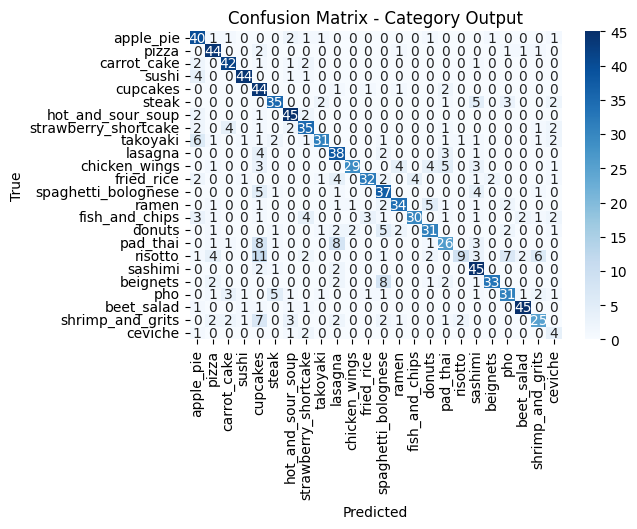

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
# Tính confusion matrix
cm_category = confusion_matrix(y_true_category, y_pred_category)
# In classification report (bao gồm Precision, Recall và F1-score)
print("Classification Report for Category Output:")
print(classification_report(y_true_category, y_pred_category))
plt.figure(figsize=(6, 4))
sns.heatmap(cm_category, annot=True, fmt="d", cmap="Blues", xticklabels=["apple_pie", "pizza", "carrot_cake", "sushi", "cupcakes", "steak", "hot_and_sour_soup",
    "strawberry_shortcake", "takoyaki", "lasagna", "chicken_wings", "fried_rice",
    "spaghetti_bolognese", "ramen", "fish_and_chips", "donuts", "pad_thai",
    "risotto", "sashimi", "beignets", "pho",
    "beet_salad", "shrimp_and_grits", "ceviche"], yticklabels=["apple_pie", "pizza", "carrot_cake", "sushi", "cupcakes", "steak", "hot_and_sour_soup",
    "strawberry_shortcake", "takoyaki", "lasagna", "chicken_wings", "fried_rice",
    "spaghetti_bolognese", "ramen", "fish_and_chips", "donuts", "pad_thai",
    "risotto", "sashimi", "beignets", "pho",
    "beet_salad", "shrimp_and_grits", "ceviche"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Category Output")
plt.show()

5/5 [==============================] - 163s 30s/step - loss: 2.1312 - category_output_loss: 1.2372 - ingredients_output_loss: 0.0692 - calorie_output_loss: 0.6446 - carbs_output_loss: 0.0809 - protein_output_loss: 0.0451 - fat_output_loss: 0.0543 - category_output_acc: 0.7103 - category_output_precision: 0.7700 - category_output_recall: 0.6848 - ingredients_output_precision: 0.6062 - ingredients_output_recall: 0.4562 - calorie_output_MAE: 0.6446 - carbs_output_MAE: 0.0809 - protein_output_MAE: 0.0451 - fat_output_MAE: 0.0543
Test Loss: 2.131159782409668
Category Output Loss: 1.2371809482574463
Ingredients Output Loss: 0.069182850420475
Calorie Output Loss: 0.6445757150650024
Carbs Output Loss: 0.08086719363927841
Protein Output Loss: 0.04505547136068344
Fat Output Loss: 0.05429773032665253
Category Output Accuracy: 0.7102721929550171
Category Output Precision: 0.7699901461601257
Category Output Recall: 0.6848112344741821
Ingredients Output Precision: 0.6061951518058777
Ingredients Outp

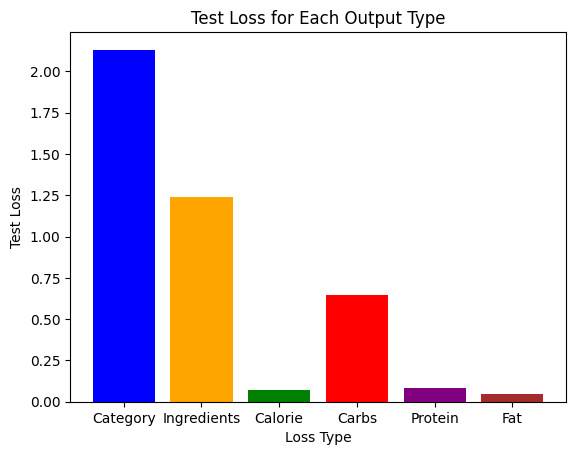

In [24]:
import matplotlib.pyplot as plt

# Load model and evaluate
flat_efficientnet = FlatEfficientNetB1Model(
    input_shape=(224, 224, 3),
    total_food_category=len(data_pipeline.one_hot_encoder.all_food_categories),
    total_ingredients_category=len(data_pipeline.one_hot_encoder.all_ingredients),
    model_config_name="finalCategory",
)

flat_efficientnet.load_model("./drive/MyDrive/FoodCaloModel/Models/model1.h5")


test_loss_values = flat_efficientnet.model.evaluate(test_dataset)
print("Test Loss:", test_loss_values[0])
print("Category Output Loss:", test_loss_values[1])
print("Ingredients Output Loss:", test_loss_values[2])
print("Calorie Output Loss:", test_loss_values[3])
print("Carbs Output Loss:", test_loss_values[4])
print("Protein Output Loss:", test_loss_values[5])
print("Fat Output Loss:", test_loss_values[6])

print("Category Output Accuracy:",test_loss_values[7])
print("Category Output Precision:", test_loss_values[8])
print("Category Output Recall:", test_loss_values[9])

print("Ingredients Output Precision:", test_loss_values[10])
print("Ingredients Output Recall:", test_loss_values[11])

print("Calorie Output MAE:", test_loss_values[12])
print("Carbs Output MAE:", test_loss_values[13])
print("Protein Output MAE:", test_loss_values[14])
print("Fat Output MAE:", test_loss_values[15])

# Plotting
loss_labels = ['Category', 'Ingredients', 'Calorie', 'Carbs', 'Protein', 'Fat']
loss_values = test_loss_values[0:6]

plt.bar(loss_labels, loss_values, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Loss Type')
plt.ylabel('Test Loss')
plt.title('Test Loss for Each Output Type')
plt.show()


Test Loss: 2.131159782409668
Category Output Loss: 1.2371809482574463
Ingredients Output Loss: 0.069182850420475
Calorie Output Loss: 0.6445757150650024
Carbs Output Loss: 0.08086719363927841
Protein Output Loss: 0.04505547136068344
Fat Output Loss: 0.05429773032665253
Category Output Accuracy: 0.7102721929550171
Category Output Precision: 0.7699901461601257
Category Output Recall: 0.6848112344741821
Ingredients Output Precision: 0.6061951518058777
Ingredients Output Recall: 0.45621657371520996
Calorie Output MAE: 0.6445757150650024
Carbs Output MAE: 0.08086719363927841
Protein Output MAE: 0.04505547136068344
Fat Output MAE: 0.05429773032665253


<ipython-input-17-8a3be832f901>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


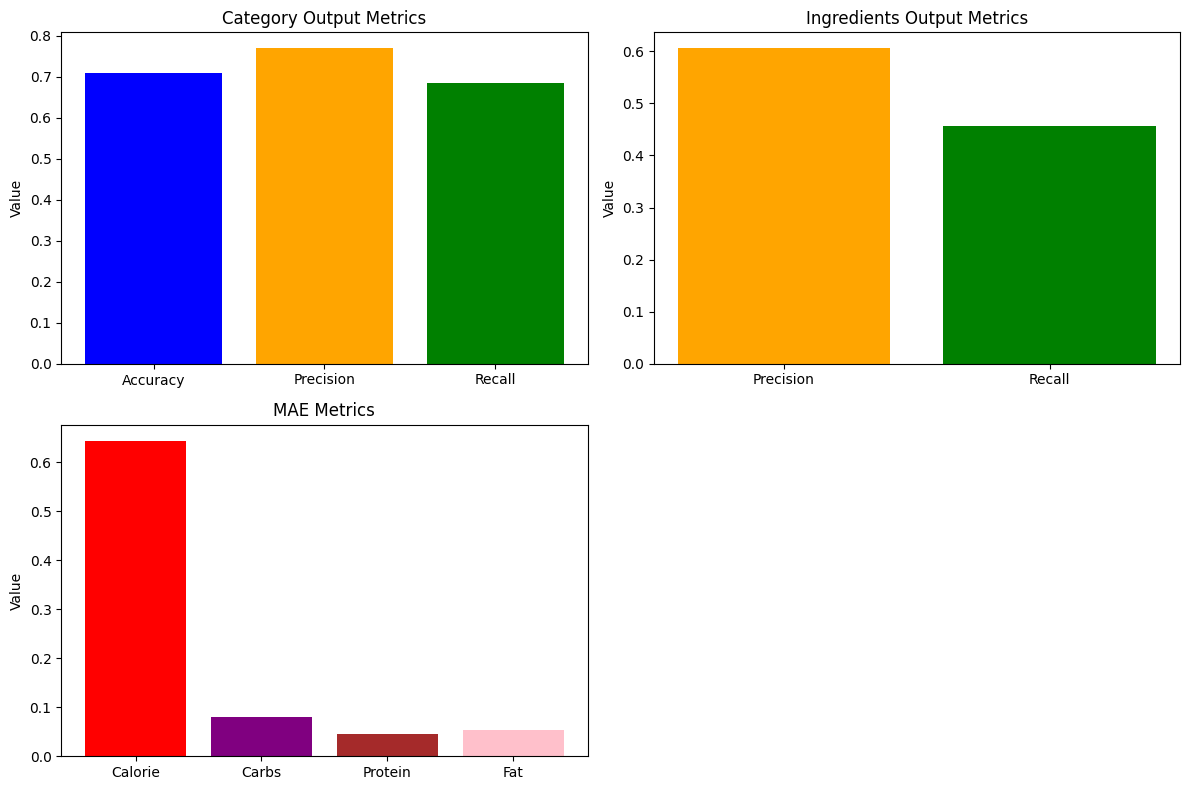

In [17]:
print("Test Loss:", test_loss_values[0])
print("Category Output Loss:", test_loss_values[1])
print("Ingredients Output Loss:", test_loss_values[2])
print("Calorie Output Loss:", test_loss_values[3])
print("Carbs Output Loss:", test_loss_values[4])
print("Protein Output Loss:", test_loss_values[5])
print("Fat Output Loss:", test_loss_values[6])

print("Category Output Accuracy:", test_loss_values[7])
print("Category Output Precision:", test_loss_values[8])
print("Category Output Recall:", test_loss_values[9])

print("Ingredients Output Precision:", test_loss_values[10])
print("Ingredients Output Recall:", test_loss_values[11])

print("Calorie Output MAE:", test_loss_values[12])
print("Carbs Output MAE:", test_loss_values[13])
print("Protein Output MAE:", test_loss_values[14])
print("Fat Output MAE:", test_loss_values[15])

# Plotting
loss_labels = ['Category', 'Ingredients', 'Calorie', 'Carbs', 'Protein', 'Fat']
loss_values = test_loss_values[1:7]  # Exclude overall test loss

plt.figure(figsize=(12, 8))

# Overall test loss
plt.bar('Overall', test_loss_values[0], color='gray')
plt.xlabel('Loss Type')
plt.ylabel('Test Loss')
plt.title('Test Loss for Each Output Type')

# Category metrics
plt.subplot(2, 2, 1)
plt.bar(['Accuracy', 'Precision', 'Recall'], [test_loss_values[7], test_loss_values[8], test_loss_values[9]], color=['blue', 'orange', 'green'])
plt.title('Category Output Metrics')
plt.ylabel('Value')

# Ingredients metrics
plt.subplot(2, 2, 2)
plt.bar(['Precision', 'Recall'], [test_loss_values[10], test_loss_values[11]], color=['orange', 'green'])
plt.title('Ingredients Output Metrics')
plt.ylabel('Value')

# MAE metrics
plt.subplot(2, 2, 3)
plt.bar(['Calorie', 'Carbs', 'Protein', 'Fat'], [test_loss_values[12], test_loss_values[13], test_loss_values[14], test_loss_values[15]], color=['red', 'purple', 'brown', 'pink'])
plt.title('MAE Metrics')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [44]:
import json
import json
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
# Load từ điển mã hóa danh mục và thành phần thực phẩm
category_encoder_path = "./encoded_food_categories.json"
ingredients_encoder_path = "./encoded_ingredients.json"

category_encoder = json.load(open(category_encoder_path, "r"))
ingredients_encoder = json.load(open(ingredients_encoder_path, "r"))

# Hàm giải mã dự đoán
def decode_predictions(category_output, ingredients_output, calorie_output, carbs_output, protein_output, fat_output):
    # Giải mã danh mục thực phẩm
    decoded_category = list(category_encoder.keys())[np.argmax(category_output)]

    # Giải mã thành phần thực phẩm
    decoded_ingredients = [list(ingredients_encoder.keys())[int(idx)] for idx, val in enumerate(ingredients_output[0]) if val > 0.5]

    # Giả sử giảm số liệu xuống để hiển thị
    decoded_calorie = round(calorie_output[0][0], 2)
    decoded_carbs = round(carbs_output[0][0], 2)
    decoded_protein = round(protein_output[0][0], 2)
    decoded_fat = round(fat_output[0][0], 2)

    return decoded_category, decoded_ingredients, decoded_calorie, decoded_carbs, decoded_protein, decoded_fat
flat_efficientnet = FlatEfficientNetB1Model(
    input_shape=(224, 224, 3),
    total_food_category=len(data_pipeline.one_hot_encoder.all_food_categories),
    total_ingredients_category=len(data_pipeline.one_hot_encoder.all_ingredients),
    model_config_name="finalCategory",
)
flat_efficientnet.load_model("./drive/MyDrive/FoodCaloModel/Models/model1.h5")
# Đường dẫn đến ảnh bạn muốn kiểm tra
image_path = "./drive/MyDrive/FoodCaloModel/ImagesTest/2248831848786842605154386796919014744.jpg"

# Sử dụng thư viện Keras để tải và chuyển đổi ảnh thành mảng numpy
img = Image.open(image_path)
img = img.resize((224, 224))  # Thay đổi kích thước thành (224, 224)

# Chuyển đổi ảnh thành mảng numpy
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)  # Mở rộng chiều để phù hợp với batch size

# Trích xuất các giá trị dự đoán từ mô hình
predictions = flat_efficientnet.model.predict(img_array)

# Trích xuất các giá trị dự đoán
category_output_prediction = predictions[0]
ingredients_output_prediction = predictions[1]
calorie_output_prediction = predictions[2]
carbs_output_prediction = predictions[3]
protein_output_prediction = predictions[4]
fat_output_prediction = predictions[5]
# Gọi hàm giải mã
decoded_category, decoded_ingredients, decoded_calorie, decoded_carbs, decoded_protein, decoded_fat = decode_predictions(category_output_prediction, ingredients_output_prediction, calorie_output_prediction, carbs_output_prediction, protein_output_prediction, fat_output_prediction)

# In ra các giá trị dự đoán đã giải mã
print("Decoded Category:", decoded_category)
print("Decoded Ingredients:", decoded_ingredients)
print("Calorie Output Prediction:", decoded_calorie)
print("Carbs Output Prediction:", decoded_carbs)
print("Protein Output Prediction:", decoded_protein)
print("Fat Output Prediction:", decoded_fat)


1/1 [==============================] - 4s 4s/step
Decoded Category: apple_pie
Decoded Ingredients: ['apple', 'butter', 'cinnamon', 'flour', 'salt', 'sugar']
Calorie Output Prediction: 1.57
Carbs Output Prediction: 0.24
Protein Output Prediction: 0.12
Fat Output Prediction: 0.14


In [43]:
import json
import json
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
# Load từ điển mã hóa danh mục và thành phần thực phẩm
category_encoder_path = "./encoded_food_categories.json"
ingredients_encoder_path = "./encoded_ingredients.json"

category_encoder = json.load(open(category_encoder_path, "r"))
ingredients_encoder = json.load(open(ingredients_encoder_path, "r"))

# Hàm giải mã dự đoán
def decode_predictions(category_output, ingredients_output, calorie_output, carbs_output, protein_output, fat_output):
    # Giải mã danh mục thực phẩm
    decoded_category = list(category_encoder.keys())[np.argmax(category_output)]

    # Giải mã thành phần thực phẩm
    decoded_ingredients = [list(ingredients_encoder.keys())[int(idx)] for idx, val in enumerate(ingredients_output[0]) if val > 0.5]

    # Giả sử giảm số liệu xuống để hiển thị
    decoded_calorie = round(calorie_output[0][0], 2)
    decoded_carbs = round(carbs_output[0][0], 2)
    decoded_protein = round(protein_output[0][0], 2)
    decoded_fat = round(fat_output[0][0], 2)

    return decoded_category, decoded_ingredients, decoded_calorie, decoded_carbs, decoded_protein, decoded_fat
flat_efficientnet = FlatEfficientNetB1Model(
    input_shape=(224, 224, 3),
    total_food_category=len(data_pipeline.one_hot_encoder.all_food_categories),
    total_ingredients_category=len(data_pipeline.one_hot_encoder.all_ingredients),
    model_config_name="finalCategory",
)
flat_efficientnet.load_model("./drive/MyDrive/FoodCaloModel/Models/model1.h5")
# Đường dẫn đến ảnh bạn muốn kiểm tra
image_path = "./drive/MyDrive/FoodCaloModel/ImagesTest/3129238443668617822820810368235928617.jpg"

# Sử dụng thư viện Keras để tải và chuyển đổi ảnh thành mảng numpy
img = Image.open(image_path)
img = img.resize((224, 224))  # Thay đổi kích thước thành (224, 224)

# Chuyển đổi ảnh thành mảng numpy
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)  # Mở rộng chiều để phù hợp với batch size

# Trích xuất các giá trị dự đoán từ mô hình
predictions = flat_efficientnet.model.predict(img_array)

# Trích xuất các giá trị dự đoán
category_output_prediction = predictions[0]
ingredients_output_prediction = predictions[1]
calorie_output_prediction = predictions[2]
carbs_output_prediction = predictions[3]
protein_output_prediction = predictions[4]
fat_output_prediction = predictions[5]
# Gọi hàm giải mã
decoded_category, decoded_ingredients, decoded_calorie, decoded_carbs, decoded_protein, decoded_fat = decode_predictions(category_output_prediction, ingredients_output_prediction, calorie_output_prediction, carbs_output_prediction, protein_output_prediction, fat_output_prediction)

# In ra các giá trị dự đoán đã giải mã
print("Decoded Category:", decoded_category)
print("Decoded Ingredients:", decoded_ingredients)
print("Calorie Output Prediction:", decoded_calorie)
print("Carbs Output Prediction:", decoded_carbs)
print("Protein Output Prediction:", decoded_protein)
print("Fat Output Prediction:", decoded_fat)


1/1 [==============================] - 3s 3s/step
Decoded Category: chicken_wings
Decoded Ingredients: ['chicken', 'garlic', 'oil', 'salt']
Calorie Output Prediction: 1.93
Carbs Output Prediction: 0.14
Protein Output Prediction: 0.12
Fat Output Prediction: 0.02


In [51]:
import json
import json
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
# Load từ điển mã hóa danh mục và thành phần thực phẩm
category_encoder_path = "./encoded_food_categories.json"
ingredients_encoder_path = "./encoded_ingredients.json"

category_encoder = json.load(open(category_encoder_path, "r"))
ingredients_encoder = json.load(open(ingredients_encoder_path, "r"))

# Hàm giải mã dự đoán
def decode_predictions(category_output, ingredients_output, calorie_output, carbs_output, protein_output, fat_output):
    # Giải mã danh mục thực phẩm
    decoded_category = list(category_encoder.keys())[np.argmax(category_output)]

    # Giải mã thành phần thực phẩm
    decoded_ingredients = [list(ingredients_encoder.keys())[int(idx)] for idx, val in enumerate(ingredients_output[0]) if val > 0.5]

    # Giả sử giảm số liệu xuống để hiển thị
    decoded_calorie = round(calorie_output[0][0], 2)
    decoded_carbs = round(carbs_output[0][0], 2)
    decoded_protein = round(protein_output[0][0], 2)
    decoded_fat = round(fat_output[0][0], 2)

    return decoded_category, decoded_ingredients, decoded_calorie, decoded_carbs, decoded_protein, decoded_fat
flat_efficientnet = FlatEfficientNetB1Model(
    input_shape=(224, 224, 3),
    total_food_category=len(data_pipeline.one_hot_encoder.all_food_categories),
    total_ingredients_category=len(data_pipeline.one_hot_encoder.all_ingredients),
    model_config_name="finalCategory",
)
flat_efficientnet.load_model("./drive/MyDrive/FoodCaloModel/Models/model1.h5")
# Đường dẫn đến ảnh bạn muốn kiểm tra
image_path = "./drive/MyDrive/FoodCaloModel/ImagesTest/67682024324373641303223203425144967752.jpg"

# Sử dụng thư viện Keras để tải và chuyển đổi ảnh thành mảng numpy
img = Image.open(image_path)
img = img.resize((224, 224))  # Thay đổi kích thước thành (224, 224)

# Chuyển đổi ảnh thành mảng numpy
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)  # Mở rộng chiều để phù hợp với batch size

# Trích xuất các giá trị dự đoán từ mô hình
predictions = flat_efficientnet.model.predict(img_array)

# Trích xuất các giá trị dự đoán
category_output_prediction = predictions[0]
ingredients_output_prediction = predictions[1]
calorie_output_prediction = predictions[2]
carbs_output_prediction = predictions[3]
protein_output_prediction = predictions[4]
fat_output_prediction = predictions[5]
# Gọi hàm giải mã
decoded_category, decoded_ingredients, decoded_calorie, decoded_carbs, decoded_protein, decoded_fat = decode_predictions(category_output_prediction, ingredients_output_prediction, calorie_output_prediction, carbs_output_prediction, protein_output_prediction, fat_output_prediction)

# In ra các giá trị dự đoán đã giải mã
print("Decoded Category:", decoded_category)
print("Decoded Ingredients:", decoded_ingredients)
print("Calorie Output Prediction:", decoded_calorie)
print("Carbs Output Prediction:", decoded_carbs)
print("Protein Output Prediction:", decoded_protein)
print("Fat Output Prediction:", decoded_fat)


1/1 [==============================] - 3s 3s/step
Decoded Category: pho
Decoded Ingredients: ['bean', 'chicken', 'cilantro', 'egg', 'fish', 'gin', 'hoisin', 'lime', 'noodles', 'oil', 'onion', 'pork', 'salt', 'scallions', 'sugar']
Calorie Output Prediction: 1.14
Carbs Output Prediction: 0.12
Protein Output Prediction: 0.06
Fat Output Prediction: 0.04


In [54]:
import json
import json
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
# Load từ điển mã hóa danh mục và thành phần thực phẩm
category_encoder_path = "./encoded_food_categories.json"
ingredients_encoder_path = "./encoded_ingredients.json"

category_encoder = json.load(open(category_encoder_path, "r"))
ingredients_encoder = json.load(open(ingredients_encoder_path, "r"))

# Hàm giải mã dự đoán
def decode_predictions(category_output, ingredients_output, calorie_output, carbs_output, protein_output, fat_output):
    # Giải mã danh mục thực phẩm
    decoded_category = list(category_encoder.keys())[np.argmax(category_output)]

    # Giải mã thành phần thực phẩm
    decoded_ingredients = [list(ingredients_encoder.keys())[int(idx)] for idx, val in enumerate(ingredients_output[0]) if val > 0.5]

    # Giả sử giảm số liệu xuống để hiển thị
    decoded_calorie = round(calorie_output[0][0], 2)
    decoded_carbs = round(carbs_output[0][0], 2)
    decoded_protein = round(protein_output[0][0], 2)
    decoded_fat = round(fat_output[0][0], 2)

    return decoded_category, decoded_ingredients, decoded_calorie, decoded_carbs, decoded_protein, decoded_fat
flat_efficientnet = FlatEfficientNetB1Model(
    input_shape=(224, 224, 3),
    total_food_category=len(data_pipeline.one_hot_encoder.all_food_categories),
    total_ingredients_category=len(data_pipeline.one_hot_encoder.all_ingredients),
    model_config_name="finalCategory",
)
flat_efficientnet.load_model("./drive/MyDrive/FoodCaloModel/Models/model1.h5")
# Đường dẫn đến ảnh bạn muốn kiểm tra
image_path = "./drive/MyDrive/FoodCaloModel/ImagesTest/165468447360342200375260239817223347182.jpg"

# Sử dụng thư viện Keras để tải và chuyển đổi ảnh thành mảng numpy
img = Image.open(image_path)
img = img.resize((224, 224))  # Thay đổi kích thước thành (224, 224)

# Chuyển đổi ảnh thành mảng numpy
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)  # Mở rộng chiều để phù hợp với batch size

# Trích xuất các giá trị dự đoán từ mô hình
predictions = flat_efficientnet.model.predict(img_array)

# Trích xuất các giá trị dự đoán
category_output_prediction = predictions[0]
ingredients_output_prediction = predictions[1]
calorie_output_prediction = predictions[2]
carbs_output_prediction = predictions[3]
protein_output_prediction = predictions[4]
fat_output_prediction = predictions[5]
# Gọi hàm giải mã
decoded_category, decoded_ingredients, decoded_calorie, decoded_carbs, decoded_protein, decoded_fat = decode_predictions(category_output_prediction, ingredients_output_prediction, calorie_output_prediction, carbs_output_prediction, protein_output_prediction, fat_output_prediction)

# In ra các giá trị dự đoán đã giải mã
print("Decoded Category:", decoded_category)
print("Decoded Ingredients:", decoded_ingredients)
print("Calorie Output Prediction:", decoded_calorie)
print("Carbs Output Prediction:", decoded_carbs)
print("Protein Output Prediction:", decoded_protein)
print("Fat Output Prediction:", decoded_fat)


1/1 [==============================] - 3s 3s/step
Decoded Category: pizza
Decoded Ingredients: ['cheese', 'oil', 'pepper', 'pizza']
Calorie Output Prediction: 3.64
Carbs Output Prediction: 0.29
Protein Output Prediction: 0.17
Fat Output Prediction: 0.19
